In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np

In [2]:
from albumentations import (
    CLAHE,
    Blur,
    OneOf,
    Compose,
    RGBShift,
    GaussNoise,
    RandomGamma,
    RandomContrast,
    RandomBrightness,
)
from albumentations.augmentations.transforms import Normalize
from albumentations.pytorch.transforms import ToTensorV2

/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from detector import Detector
from torch.utils.data import DataLoader
from trainer.datasets import ListDataset

In [4]:
from trainer.encoder import (
    DataEncoder,
    decode_boxes,
    encode_boxes,
    generate_anchors,
    generate_anchor_grid,
)

In [5]:
classes=[
    "__background__",
    "biker",
    "car",
    "pedestrian",
    "trafficLight",
    "trafficLight-Green",
    "trafficLight-GreenLeft",
    "trafficLight-Red",
    "trafficLight-RedLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft",
    "truck"
]

In [6]:
dataset_test = ListDataset(
    root_dir="../../../Datasets/Road_Scene_Object_Detection",
    data_dir = 'export',
    list_file='annots_transformed_test.txt',
    classes=[
        "__background__",
        "biker",
        "car",
        "pedestrian",
        "trafficLight",
        "trafficLight-Green",
        "trafficLight-GreenLeft",
        "trafficLight-Red",
        "trafficLight-RedLeft",
        "trafficLight-Yellow",
        "trafficLight-YellowLeft",
        "truck"
    ],
    mode='val',
    transform=Compose([Normalize(), ToTensorV2()]),
    input_size=300
)
loader_test = DataLoader(
    dataset=dataset_test,
    batch_size=32,
    shuffle=False,
    collate_fn=dataset_test.collate_fn,
    num_workers=5,
    pin_memory=True
)

In [7]:
index = random.randrange(len(loader_test.dataset))

In [8]:
image, gt_boxes, _ = loader_test.dataset[index]

In [9]:
device = torch.device("cuda")
image = image.to(device).clone()

In [10]:
model = Detector(len(classes))

In [11]:
model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"

In [12]:
model.load_state_dict(
                torch.load(model_path)
            )
model = model.eval()

In [13]:
std = (0.229, 0.224, 0.225)
mean = (0.485, 0.456, 0.406)

std = torch.Tensor(std)
mean = torch.Tensor(mean)

In [14]:
model.to(device)

Detector(
  (fpn): FPN(
    (feature_extractor): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [15]:
device

device(type='cuda')

In [16]:
loc_preds, cls_preds = model(image.unsqueeze(0))

In [17]:
cls_preds, loc_preds

(tensor([[[ 25.5860,   0.1913,  -1.5053,  ...,  -3.2789,  -0.1414,  -7.8271],
          [ 23.3576,   0.9003,   0.0665,  ...,  -5.2984,  -4.1899,  -6.2944],
          [ 23.2045,   0.6378,   0.8893,  ...,  -3.5225,  -3.6555,  -4.3234],
          ...,
          [ 46.2530,  19.1426,  19.1991,  ..., -10.1093,  -1.8026, -14.8418],
          [ 40.3464,  24.1163,   7.0957,  ..., -10.3441, -14.2236,  -9.8906],
          [ 38.6209,  13.3629,   4.8795,  ...,  -4.5276,  -4.8813,  -7.9495]]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([[[ 0.0064, -0.0228, -0.2861,  0.0570],
          [-0.0292, -0.0767, -0.4367,  0.0983],
          [-0.0691, -0.1782, -0.3967,  0.3646],
          ...,
          [ 0.0138,  0.1412, -0.2165, -0.1603],
          [ 0.0338, -0.0047, -0.4867, -0.0701],
          [ 0.0011, -0.0272, -0.3702,  0.1451]]], device='cuda:0',
        grad_fn=<CatBackward>))

In [18]:
with torch.no_grad():
    img = image.cpu()
    img.mul_(std[:, None, None]).add_(mean[:, None, None])
    img = torch.clamp(img, min=0.0, max=1.0)
    img = img.numpy().transpose(1, 2, 0)

    img = (img * 255.).astype(np.uint8)
    gt_img = img.copy()
    pred_img = img.copy()

    for box in gt_boxes:
        gt_img = cv2.rectangle(
            gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0),
            thickness=2
        )

    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

    if c_dets.size > 0:
        boxes = c_dets[:, :4]
        for box in boxes:
            pred_img = cv2.rectangle(
                pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                thickness=2
            )

/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/SSD_Trainer/trainer/encoder.py:58: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  ids = (class_conf > cls_threshold).nonzero().squeeze()


In [19]:
samples[0]

[[], array([[110.194984  , 150.10185   , 119.505806  , 172.12743   ,
           0.999998  ],
        [112.916466  , 147.03416   , 129.5961    , 176.91158   ,
           0.99999857],
        [ 55.951195  , 151.40337   ,  72.62675   , 172.70732   ,
           0.9999999 ],
        [ 76.975105  , 141.93071   , 115.54575   , 190.94228   ,
           1.        ],
        [ 30.006063  , 151.71124   ,  49.907722  , 179.16592   ,
           1.        ],
        [127.60211   , 142.22128   , 148.33496   , 180.72037   ,
           1.        ],
        [171.16089   , 142.92197   , 230.50882   , 196.19022   ,
           1.        ],
        [  0.7825365 , 156.03766   ,  13.830743  , 187.46606   ,
           1.        ],
        [147.66019   , 131.95633   , 179.2555    , 188.75897   ,
           1.        ]], dtype=float32), array([[243.68504  , 143.28922  , 254.41603  , 179.66394  ,   0.8289954],
        [228.26013  , 144.02376  , 236.94553  , 174.65019  ,   0.9153588]],
       dtype=float32), array

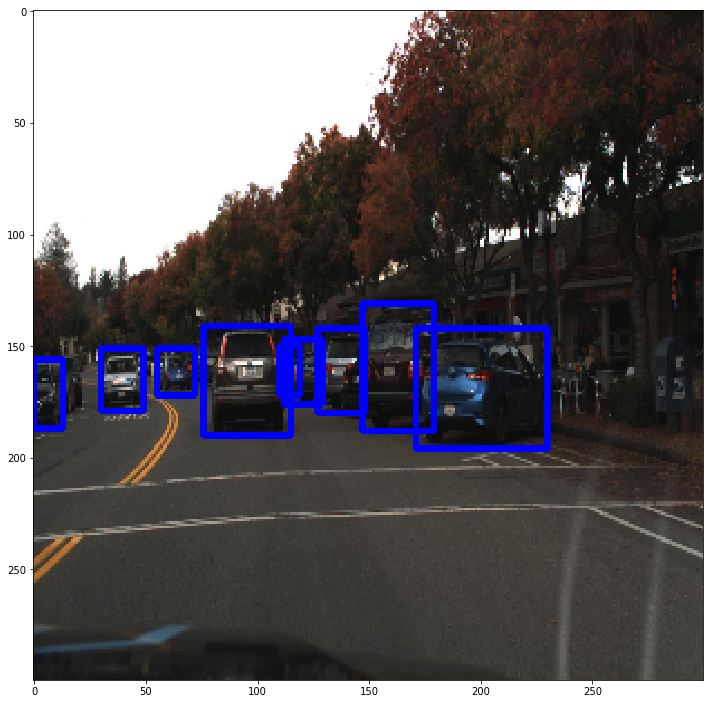

In [20]:
plt.figure(figsize = (12,18))
plt.imshow(pred_img)
plt.show()

In [21]:
pred_img.shape

(300, 300, 3)

In [24]:
loc_preds.shape

torch.Size([1, 17451, 4])

In [25]:
cls_preds.shape

torch.Size([1, 17451, 12])

In [27]:
with torch.no_grad():
    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

In [30]:
len(samples)

[[[], array([[110.194984  , 150.10185   , 119.505806  , 172.12743   ,
            0.999998  ],
         [112.916466  , 147.03416   , 129.5961    , 176.91158   ,
            0.99999857],
         [ 55.951195  , 151.40337   ,  72.62675   , 172.70732   ,
            0.9999999 ],
         [ 76.975105  , 141.93071   , 115.54575   , 190.94228   ,
            1.        ],
         [ 30.006063  , 151.71124   ,  49.907722  , 179.16592   ,
            1.        ],
         [127.60211   , 142.22128   , 148.33496   , 180.72037   ,
            1.        ],
         [171.16089   , 142.92197   , 230.50882   , 196.19022   ,
            1.        ],
         [  0.7825365 , 156.03766   ,  13.830743  , 187.46606   ,
            1.        ],
         [147.66019   , 131.95633   , 179.2555    , 188.75897   ,
            1.        ]], dtype=float32), array([[243.68504  , 143.28922  , 254.41603  , 179.66394  ,   0.8289954],
         [228.26013  , 144.02376  , 236.94553  , 174.65019  ,   0.9153588]],
        d